
# Algorithmic Trading Machine Learning Project

This is a machine learning project that will take in S&P 500 stock price data and use an unsupervised learning trading strategy. This is strictly for educational purposes and is to help me learn machine learning.

1. Install packages.

In [31]:
# Packages installed:
# pandas
# pandas_ta
# numpy
# matplotlib
# statsmodels
# pandas_datareader
# datetime
# yfinance
# sklearn
# PyPortfolioOpt

!pip install pandas pandas_ta numpy matplotlib statsmodels pandas_datareader datetime yfinance sklearn PyPortfolioOpt -q


You should consider upgrading via the 'c:\users\kyle\onedrive\desktop\project folders\algoirthmic trading\my_virtual_env\scripts\python.exe -m pip install --upgrade pip' command.


2. Download S&P 500 data

In [32]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
warnings.filterwarnings('ignore')

# Read the S&P 500 list of companies 
# pd.read_html is used for reading HTML tables from a webpage
sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

# Remove the dot from the symbol names
sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')

# Get the list of symbols
symbols_list = sp500['Symbol'].unique().tolist()
symbols_list

# Define the start and end dates
end_date = '2023-09-27'
start_date = pd.to_datetime(end_date) - pd.DateOffset(365 * 8)

# Download the data
df = yf.download(tickers = symbols_list, 
                 start=start_date, 
                 end=end_date).stack()

df.index.names = ['date', 'ticker']
df.columns = df.columns.str.lower()


[*********************100%%**********************]  503 of 503 completed

3 Failed downloads:
['VLTO', 'SOLV', 'GEV']: YFChartError("%ticker%: Data doesn't exist for startDate = 1443499200, endDate = 1695787200")


2. Technical indicators for all the stocks

In [33]:
# Garman-Klass volatility
# Used to estimate volitility of an asset
df['garman_klass_vol'] = ((np.log(df['high']) - np.log(df['low'])) **2/2 - ((2 * np.log(2) - 1) * (np.log(df['adj close']) - np.log(df['open'])) ** 2))

# RSI
# Relative Strength Index used for overbought and oversold areas
df['rsi'] = df.groupby(level = 1)['adj close'].transform(lambda x: pandas_ta.rsi(close = x, length = 20))

# Bolinger Bands
# Consists of 3 bands, the lower, middle and upper band
df['bb_low'] = df.groupby(level = 1)['adj close'].transform(lambda x: pandas_ta.bbands(close = np.log1p(x), length = 20).iloc[:, 0])
df['bb_med'] = df.groupby(level = 1)['adj close'].transform(lambda x: pandas_ta.bbands(close = np.log1p(x), length = 20).iloc[:, 1])
df['bb_high'] = df.groupby(level = 1)['adj close'].transform(lambda x: pandas_ta.bbands(close = np.log1p(x), length = 20).iloc[:, 2])

# ATR
# Average True Range used to measure volatility
def compute_atr(stock_data):
    atr = pandas_ta.atr(high = stock_data['high'],
                        low = stock_data['low'],
                        close = stock_data['adj close'],
                        length = 14)
    return atr.sub(atr.mean()).div(atr.std())
df['atr'] = df.groupby(level = 1, group_keys = False).apply(compute_atr)

# MACD
# Identify trend direction and momentum
def compute_macd(close):
    macd = pandas_ta.macd(close = close, length = 20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level = 1, group_keys = False)['adj close'].apply(compute_macd)

# Volume
# The number of shares traded
df['dollar_vol'] = (df['adj close'] * df['volume']) / 1e6
df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2015-09-29 A        31.425230   33.740002   34.060001   33.240002   33.360001   
           AAL      37.361622   39.180000   39.770000   38.790001   39.049999   
           AAPL     24.651127   27.264999   28.377501   26.965000   28.207500   
           ABBV     36.334900   52.790001   54.189999   51.880001   53.099998   
           ABT      33.478706   39.500000   40.150002   39.029999   39.259998   
...                       ...         ...         ...         ...         ...   
2023-09-26 XYL      88.736305   89.519997   90.849998   89.500000   90.379997   
           YUM     122.211006  124.010002  124.739998  123.449997  124.239998   
           ZBH     111.534821  112.459999  117.110001  112.419998  116.769997   
           ZBRA    223.960007  223.960007  226.649994  222.580002  225.970001   
           ZTS     175.547714  176.869995  178.449997  176.270004  176.580002   

Price                   volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2015-09-29 A         2252400.0         -0.001082        NaN       NaN   
           AAL       7478800.0         -0.000443        NaN       NaN   
           AAPL    293461600.0         -0.005712        NaN       NaN   
           ABBV     12842800.0         -0.054655        NaN       NaN   
           ABT      12287500.0         -0.009402        NaN       NaN   
...                        ...               ...        ...       ...   
2023-09-26 XYL       1322400.0         -0.000018  26.146729  4.485761   
           YUM       1500600.0         -0.000051  36.057170  4.811707   
           ZBH       3610500.0          0.000022  31.893235  4.745884   
           ZBRA       355400.0          0.000133  29.494977  5.400991   
           ZTS       1463200.0          0.000062  42.623488  5.156108   

Price                bb_med   bb_high       atr      macd   dollar_vol  
date       ticker                                                       
2015-09-29 A            NaN       NaN       NaN       NaN    70.782188  
           AAL          NaN       NaN       NaN       NaN   279.420098  
           AAPL         NaN       NaN       NaN       NaN  7234.159131  
           ABBV         NaN       NaN       NaN       NaN   466.641852  
           ABT          NaN       NaN       NaN       NaN   411.369604  
...                     ...       ...       ...       ...          ...  
2023-09-26 XYL     4.567684  4.649607 -2.967042 -2.159188   117.344890  
           YUM     4.841672  4.871637 -2.813230 -1.363696   183.389836  
           ZBH     4.785551  4.825217 -2.109952 -0.881067   402.696470  
           ZBRA    5.539167  5.677342 -0.057389 -1.600791    79.595386  
           ZTS     5.214922  5.273735 -0.720920 -1.188278   256.861415  

[987967 rows x 14 columns]

3. Filter top 150 most liquid

In [34]:
# Define the list of columns to keep
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_vol', 'volume', 'open', 'high', 'low', 'close']]

data = pd.concat([df.unstack('ticker')['dollar_vol'].resample('M').mean().stack('ticker').to_frame('dollar_vol'),
df.unstack()[last_cols].resample('M').last().stack('ticker')], axis = 1).dropna()

data

dollar_vol   adj close       atr   bb_high    bb_low  \
date       ticker                                                          
2015-11-30 A        135.740904   38.950890 -0.948795  3.689080  3.544191   
           AAL      287.915810   39.429928  1.473834  3.827636  3.672028   
           AAPL    4023.983936   26.854137 -0.326058  3.368302  3.281679   
           ABBV     337.563930   40.393524  0.572008  3.823191  3.726695   
           ABT      211.659041   38.293575  0.553866  3.699763  3.656055   
...                        ...         ...       ...       ...       ...   
2023-09-30 OTIS     154.361755   78.356499 -2.269284  4.460712  4.370137   
           ABNB    1633.500725  132.279999 -1.006939  5.024801  4.857047   
           CEG      196.670368  107.862022 -0.705545  4.732493  4.652147   
           GEHC     212.275852   66.130219 -0.905988  4.270508  4.155436   
           KVUE     670.804278   20.006195 -2.650791  3.164168  3.014275   

                     bb_med  garman_klass_vol      macd        rsi  
date       ticker                                                   
2015-11-30 A       3.616636         -0.002098  0.567157  73.421427  
           AAL     3.749832         -0.000966 -0.418772  40.718913  
           AAPL    3.324990         -0.003307 -0.142789  55.537370  
           ABBV    3.774943         -0.059549  0.145677  49.376840  
           ABT     3.677909         -0.011216  0.335557  56.962590  
...                     ...               ...       ...        ...  
2023-09-30 OTIS    4.415425         -0.000097 -1.534536  33.116229  
           ABNB    4.940924          0.000213 -0.037854  44.494127  
           CEG     4.692320          0.000131  0.366876  55.245468  
           GEHC    4.212972          0.000185 -1.116463  40.922338  
           KVUE    3.089221         -0.000159 -1.435620  35.706355  

[46648 rows x 9 columns]

In [35]:
# Rolling average 5 year
data['dollar_vol'] = (data.loc[:,'dollar_vol'].unstack('ticker').rolling(5*12, min_periods = 12).mean().stack())

# Rank the stocks by dollar volume
data['dollar_vol_rank'] = (data.groupby('date')['dollar_vol'].rank(ascending=False))

# Keep only the top 150 stocks by dollar volume
data = data[data['dollar_vol_rank']<150].drop(['dollar_vol', 'dollar_vol_rank'], axis=1)

data

adj close       atr   bb_high    bb_low    bb_med  \
date       ticker                                                       
2016-10-31 AAL      39.134335  1.161163  3.706314  3.604673  3.655494   
           AAPL     26.212473 -0.963372  3.351997  3.294237  3.323117   
           ABBV     40.245121  0.257529  3.861774  3.753446  3.807610   
           ABT      34.293453 -0.483970  3.655580  3.554632  3.605106   
           ACN     103.569618  0.222959  4.660617  4.637342  4.648980   
...                       ...       ...       ...       ...       ...   
2023-09-30 XOM     113.372101 -1.345888  4.767283  4.687091  4.727187   
           MRNA     98.120003 -0.529511  4.788149  4.582514  4.685332   
           UBER     44.270000 -0.746098  3.917801  3.806654  3.862227   
           CRWD    160.479996 -0.744862  5.181204  5.026187  5.103696   
           ABNB    132.279999 -1.006939  5.024801  4.857047  4.940924   

                   garman_klass_vol      macd        rsi  
date       ticker                                         
2016-10-31 AAL            -0.000176  1.131596  62.203576  
           AAPL           -0.002468 -0.195978  49.891067  
           ABBV           -0.046691 -0.760594  27.477760  
           ABT            -0.007492 -0.650888  38.008880  
           ACN            -0.004643 -0.135457  53.823625  
...                             ...       ...        ...  
2023-09-30 XOM            -0.000065  1.400624  59.440184  
           MRNA            0.000146 -0.376899  38.747314  
           UBER            0.000441 -0.133973  45.005268  
           CRWD            0.000144  0.245950  51.534803  
           ABNB            0.000213 -0.037854  44.494127  

[12516 rows x 8 columns]

4. Calculate monthly returns for different times


In [36]:
# Calculate the returns function
def calculate_returns(df):
    # 95%
    outlier_cutoff = 0.005
    # Define the time frames
    lags = [1,2,3,6,9,12]

    # Calculate the returns
    for lag in lags:
        df[f'return_{lag}m'] = df['adj close'].pct_change(lag).pipe(lambda x: x.clip(lower = x.quantile(outlier_cutoff), upper = x.quantile(1-outlier_cutoff))).add(1).pow(1/lag).sub(1)
    return df
data = data.groupby(level = 1, group_keys = False).apply(calculate_returns).dropna()
data



adj close       atr   bb_high    bb_low    bb_med  \
date       ticker                                                       
2017-10-31 AAL      45.534168  1.125077  3.994389  3.849110  3.921750   
           AAPL     39.713894 -0.532950  3.688475  3.594730  3.641603   
           ABBV     67.491142  1.577038  4.289423  4.196702  4.243063   
           ABT      48.493374 -0.019444  3.939707  3.892568  3.916137   
           ACN     129.399689  0.250124  4.882034  4.802675  4.842354   
...                       ...       ...       ...       ...       ...   
2023-09-30 XOM     113.372101 -1.345888  4.767283  4.687091  4.727187   
           MRNA     98.120003 -0.529511  4.788149  4.582514  4.685332   
           UBER     44.270000 -0.746098  3.917801  3.806654  3.862227   
           CRWD    160.479996 -0.744862  5.181204  5.026187  5.103696   
           ABNB    132.279999 -1.006939  5.024801  4.857047  4.940924   

                   garman_klass_vol      macd        rsi  return_1m  \
date       ticker                                                     
2017-10-31 AAL            -0.000363 -0.018697  41.051781  -0.014108   
           AAPL           -0.001055 -0.039276  69.196651   0.096807   
           ABBV           -0.034008  0.473815  55.247847   0.022728   
           ABT            -0.005190  0.276132  53.844909   0.021276   
           ACN            -0.003925  0.352342  69.365138   0.064180   
...                             ...       ...        ...        ...   
2023-09-30 XOM            -0.000065  1.400624  59.440184   0.046947   
           MRNA            0.000146 -0.376899  38.747314  -0.132219   
           UBER            0.000441 -0.133973  45.005268  -0.062672   
           CRWD            0.000144  0.245950  51.534803  -0.015641   
           ABNB            0.000213 -0.037854  44.494127   0.005549   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2017-10-31 AAL      0.022981  -0.023860   0.016495   0.007008    0.012702  
           AAPL     0.015249   0.044955   0.028875   0.038941    0.035228  
           ABBV     0.098590   0.091379   0.056495   0.047273    0.044026  
           ABT      0.034308   0.034801   0.038672   0.031320    0.029294  
           ACN      0.048454   0.037202   0.028692   0.027398    0.018728  
...                      ...        ...        ...        ...         ...  
2023-09-30 XOM      0.046139   0.030496   0.012838   0.008747    0.027037  
           MRNA    -0.086803  -0.068763  -0.071952  -0.064976   -0.015431  
           UBER    -0.053920   0.008422   0.057244   0.066838    0.043691  
           CRWD    -0.003656   0.029981   0.026391   0.047942   -0.002216  
           ABNB    -0.067704   0.010603   0.010289   0.049124    0.019401  

[10344 rows x 14 columns]

5. Download Fama-French factors and calculate rolling factor betas.


In [37]:
# Get the Fama-French factors data from library
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
               'famafrench',
               start = '2010',)[0].drop('RF', axis = 1)

# Convert the index to datetime
factor_data.index = factor_data.index.to_timestamp()
factor_data.index.name = 'date'

# Get last value of each month and divide by 100
factor_data = factor_data.resample('M').last().div(100)

# Join the factor with our data we pulled from S&P 500
factor_data = factor_data.join(data['return_1m']).sort_index()
factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2017-10-31 AAL     0.0225 -0.0194  0.0020  0.0093 -0.0325  -0.014108
           AAPL    0.0225 -0.0194  0.0020  0.0093 -0.0325   0.096807
           ABBV    0.0225 -0.0194  0.0020  0.0093 -0.0325   0.022728
           ABT     0.0225 -0.0194  0.0020  0.0093 -0.0325   0.021276
           ACN     0.0225 -0.0194  0.0020  0.0093 -0.0325   0.064180
...                   ...     ...     ...     ...     ...        ...
2023-09-30 VRTX   -0.0524 -0.0181  0.0151  0.0187 -0.0082   0.009617
           VZ     -0.0524 -0.0181  0.0151  0.0187 -0.0082  -0.056890
           WFC    -0.0524 -0.0181  0.0151  0.0187 -0.0082  -0.015500
           WMT    -0.0524 -0.0181  0.0151  0.0187 -0.0082  -0.000677
           XOM    -0.0524 -0.0181  0.0151  0.0187 -0.0082   0.046947

[10344 rows x 6 columns]

In [38]:
# Filter stocks without 10 months of data
# We need at least 10 months of data to calculate the factor or else the model will break
observations = factor_data.groupby(level = 1).size()
valid_stocks = observations[observations >= 10]
factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]
factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2017-10-31 AAL     0.0225 -0.0194  0.0020  0.0093 -0.0325  -0.014108
           AAPL    0.0225 -0.0194  0.0020  0.0093 -0.0325   0.096807
           ABBV    0.0225 -0.0194  0.0020  0.0093 -0.0325   0.022728
           ABT     0.0225 -0.0194  0.0020  0.0093 -0.0325   0.021276
           ACN     0.0225 -0.0194  0.0020  0.0093 -0.0325   0.064180
...                   ...     ...     ...     ...     ...        ...
2023-09-30 VRTX   -0.0524 -0.0181  0.0151  0.0187 -0.0082   0.009617
           VZ     -0.0524 -0.0181  0.0151  0.0187 -0.0082  -0.056890
           WFC    -0.0524 -0.0181  0.0151  0.0187 -0.0082  -0.015500
           WMT    -0.0524 -0.0181  0.0151  0.0187 -0.0082  -0.000677
           XOM    -0.0524 -0.0181  0.0151  0.0187 -0.0082   0.046947

[10314 rows x 6 columns]

In [39]:
# calculate rolling betas.
# 24 month window size
betas = factor_data.groupby(level = 1,
                    group_keys = False).apply(lambda x: RollingOLS(endog = x['return_1m'], exog = sm.add_constant( x.drop('return_1m', axis = 1)),
                                              window = min(24, x.shape[0]),
                                              min_nobs = len(x.columns) + 1)
.fit()
.params
.drop('const', axis = 1))

betas

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2017-10-31 AAL          NaN       NaN       NaN       NaN       NaN
           AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2023-09-30 VRTX    0.456835 -0.444629 -0.314191 -0.077989  0.802008
           VZ      0.332723 -0.166037  0.265928  0.311103  0.108624
           WFC     1.120622  0.297484  2.062607 -0.441341 -1.519516
           WMT     0.700775 -0.313572 -0.413680 -0.141574  0.508837
           XOM     0.983098 -1.094427  1.756406 -0.640016 -0.368887

[10314 rows x 5 columns]

In [44]:
# Fix null values
# Total of 18 features to be used for the machine learning model
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']
data = data.join(betas.groupby('ticker').shift())
data.loc[:, factors] = data.groupby('ticker', group_keys = False)[factors].apply(lambda x: x.fillna(x.mean()))
data = data.drop('adj close', axis = 1)
data = data.dropna()
data.info()

# The data is ready for the machine learning model.
# The model will predict which stocks should be chosen to maximize gains for the next month.

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10094 entries, (Timestamp('2017-10-31 00:00:00'), 'AAL') to (Timestamp('2023-09-30 00:00:00'), 'CRWD')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   atr               10094 non-null  float64
 1   bb_high           10094 non-null  float64
 2   bb_low            10094 non-null  float64
 3   bb_med            10094 non-null  float64
 4   garman_klass_vol  10094 non-null  float64
 5   macd              10094 non-null  float64
 6   rsi               10094 non-null  float64
 7   return_1m         10094 non-null  float64
 8   return_2m         10094 non-null  float64
 9   return_3m         10094 non-null  float64
 10  return_6m         10094 non-null  float64
 11  return_9m         10094 non-null  float64
 12  return_12m        10094 non-null  float64
 13  Mkt-RF            10094 non-null  float64
 14  SMB               10094 non-null  float64
 15  HML       

6. Fit K-Means Clustering algortithm to group similar assets based on features.

In [56]:
from sklearn.cluster import KMeans
def get_clusters(df):
    df['cluster'] =  KMeans(n_clusters = 4,
                            random_state = 0,
                            init = initial_centroids).fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys = False).apply(get_clusters)
data

atr   bb_high    bb_low    bb_med  garman_klass_vol  \
date       ticker                                                             
2017-10-31 AAL     1.125077  3.994389  3.849110  3.921750         -0.000363   
           AAPL   -0.532950  3.688475  3.594730  3.641603         -0.001055   
           ABBV    1.577038  4.289423  4.196702  4.243063         -0.034008   
           ABT    -0.019444  3.939707  3.892568  3.916137         -0.005190   
           ACN     0.250124  4.882034  4.802675  4.842354         -0.003925   
...                     ...       ...       ...       ...               ...   
2023-09-30 WMT    -2.579273  4.019915  3.984976  4.002446         -0.000041   
           XOM    -1.345888  4.767283  4.687091  4.727187         -0.000065   
           MRNA   -0.529511  4.788149  4.582514  4.685332          0.000146   
           UBER   -0.746098  3.917801  3.806654  3.862227          0.000441   
           CRWD   -0.744862  5.181204  5.026187  5.103696          0.000144   

                       macd        rsi  return_1m  return_2m  return_3m  \
date       ticker                                                         
2017-10-31 AAL    -0.018697  41.051781  -0.014108   0.022981  -0.023860   
           AAPL   -0.039276  69.196651   0.096807   0.015249   0.044955   
           ABBV    0.473815  55.247847   0.022728   0.098590   0.091379   
           ABT     0.276132  53.844909   0.021276   0.034308   0.034801   
           ACN     0.352342  69.365138   0.064180   0.048454   0.037202   
...                     ...        ...        ...        ...        ...   
2023-09-30 WMT     0.399458  54.722483  -0.000677   0.010014   0.012354   
           XOM     1.400624  59.440184   0.046947   0.046139   0.030496   
           MRNA   -0.376899  38.747314  -0.132219  -0.086803  -0.068763   
           UBER   -0.133973  45.005268  -0.062672  -0.053920   0.008422   
           CRWD    0.245950  51.534803  -0.015641  -0.003656   0.029981   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2017-10-31 AAL      0.016495   0.007008    0.012702  1.265330  1.314923   
           AAPL     0.028875   0.038941    0.035228  1.276026 -0.271593   
           ABBV     0.056495   0.047273    0.044026  0.494533  0.362679   
           ABT      0.038672   0.031320    0.029294  0.828390 -0.199396   
           ACN      0.028692   0.027398    0.018728  1.199020 -0.166370   
...                      ...        ...         ...       ...       ...   
2023-09-30 WMT      0.017574   0.016553    0.020256  0.740244 -0.259783   
           XOM      0.012838   0.008747    0.027037  1.005607 -1.051739   
           MRNA    -0.071952  -0.064976   -0.015431  1.154879  0.766422   
           UBER     0.057244   0.066838    0.043691  1.078514  1.163168   
           CRWD     0.026391   0.047942   -0.002216  0.594732 -0.940715   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2017-10-31 AAL     0.600746  0.459424  0.563336        1  
           AAPL   -0.591214  0.647541  0.458388        3  
           ABBV   -0.032806  0.242183  0.164053        2  
           ABT    -0.529385  0.251776  0.970502        2  
           ACN    -0.328322  0.268151  0.168634        3  
...                     ...       ...       ...      ...  
2023-09-30 WMT    -0.522482 -0.125198  0.642483        2  
           XOM     1.707636 -0.674966 -0.284575        3  
           MRNA   -1.163095  0.593370  0.989911        1  
           UBER   -0.257055 -1.482917 -0.449948        1  
           CRWD   -0.678313 -2.449974 -0.814519        2  

[10094 rows x 19 columns]

In [47]:
# Plots the clusters ATR and RSI
def plot_clusters(data):
    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]

    plt.scatter(cluster_0.iloc[:,0], cluster_0.iloc[:,6], color = 'red', label = 'cluster 0')
    plt.scatter(cluster_1.iloc[:,0], cluster_1.iloc[:,6], color = 'green', label = 'cluster 1')
    plt.scatter(cluster_2.iloc[:,0], cluster_2.iloc[:,6], color = 'blue', label = 'cluster 2')
    plt.scatter(cluster_3.iloc[:,0], cluster_3.iloc[:,6], color = 'black', label = 'cluster 3')
    
    plt.legend()
    plt.show()
    return

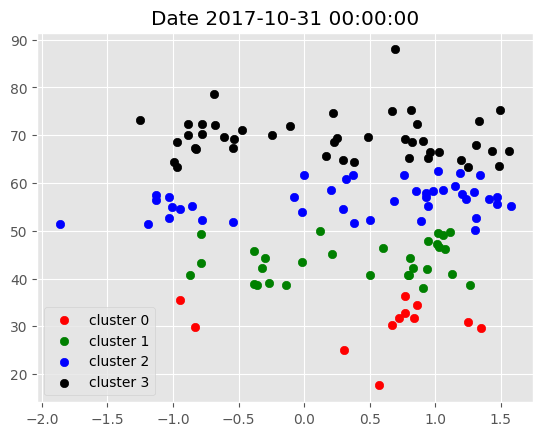

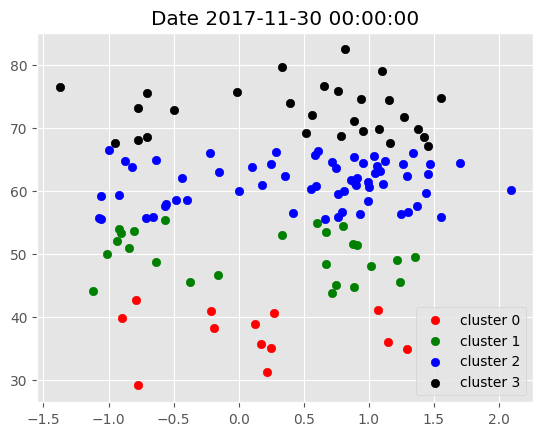

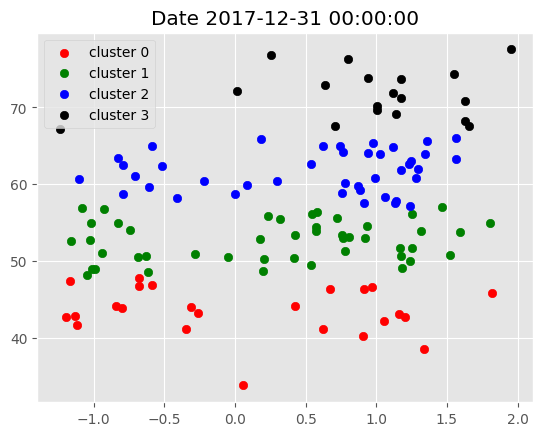

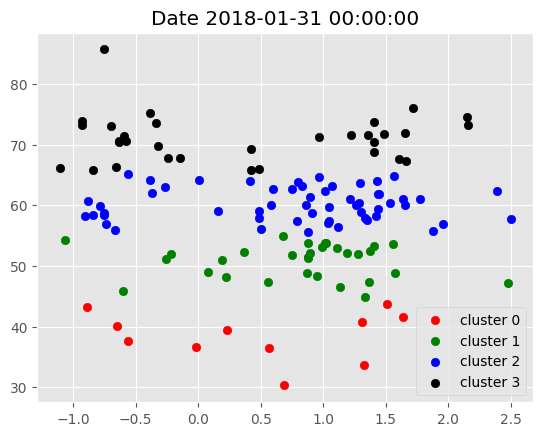

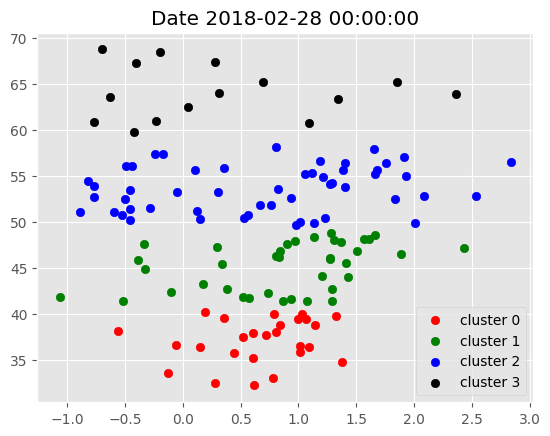

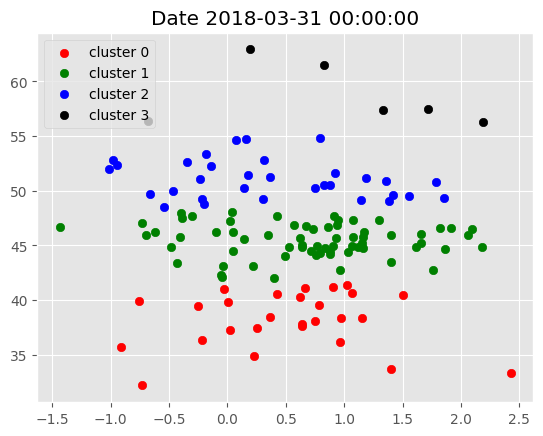

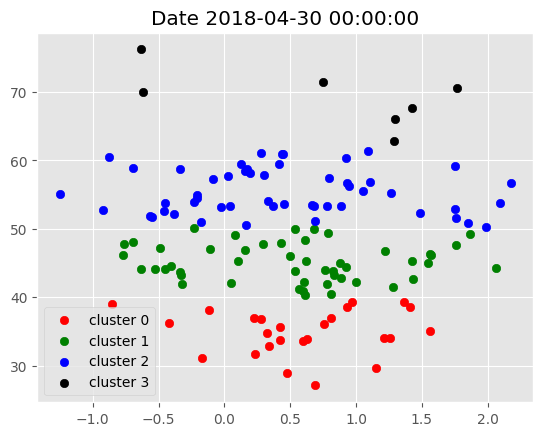

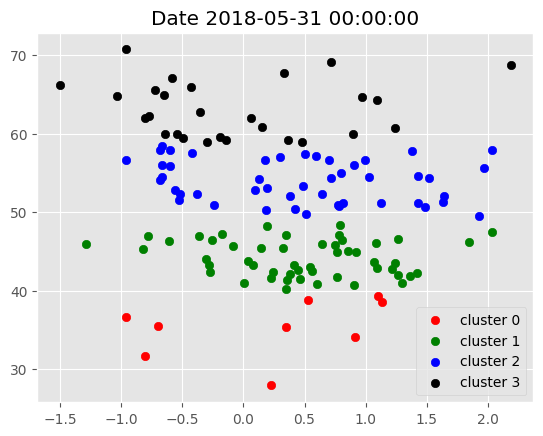

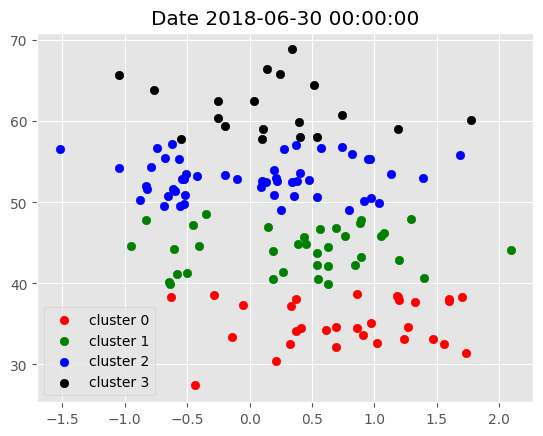

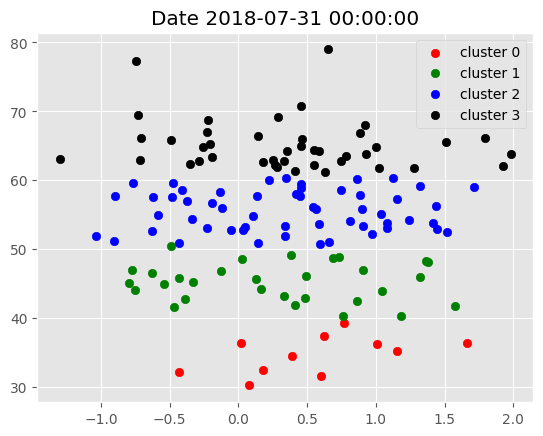

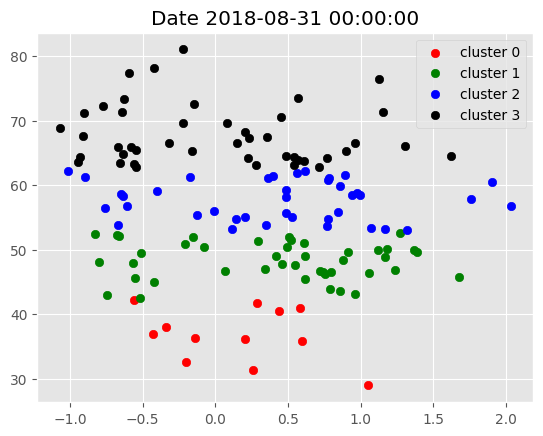

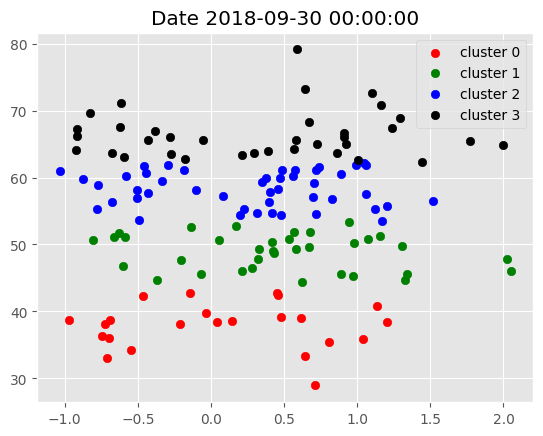

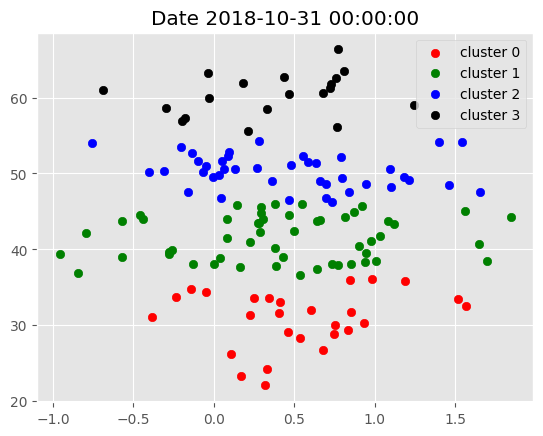

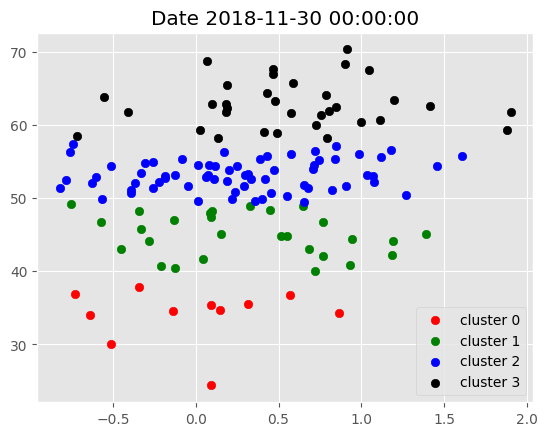

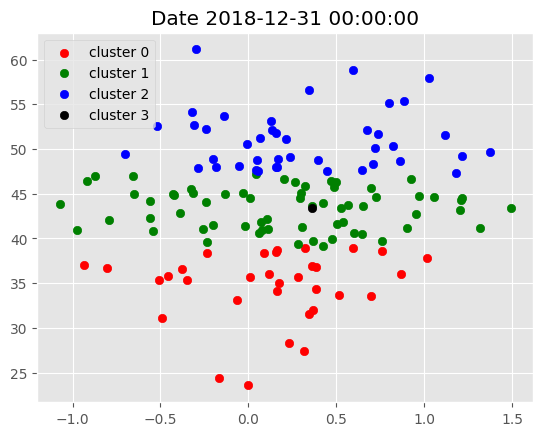

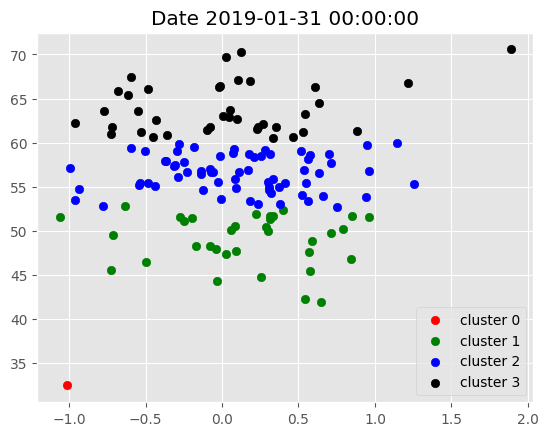

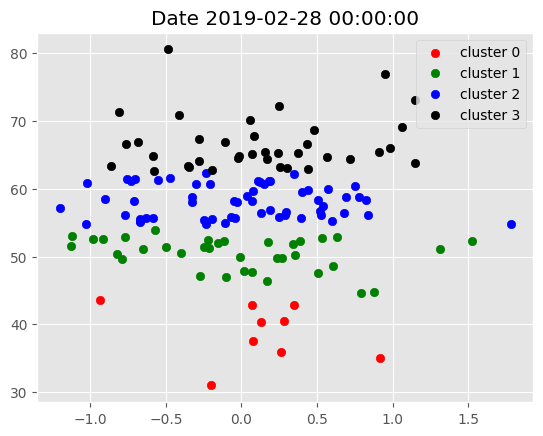

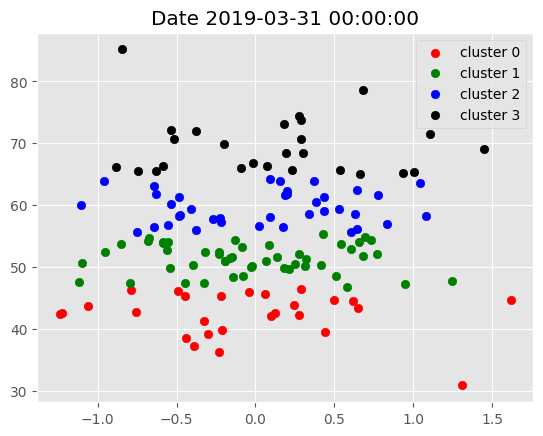

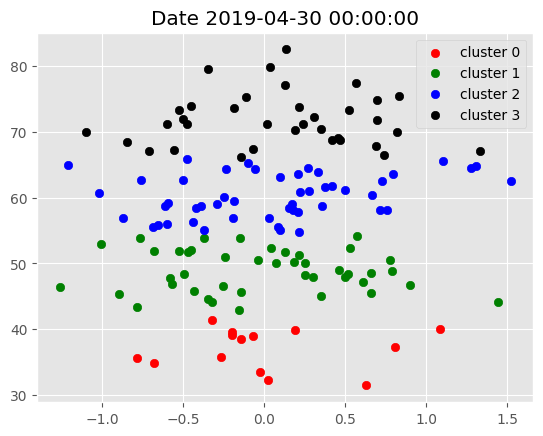

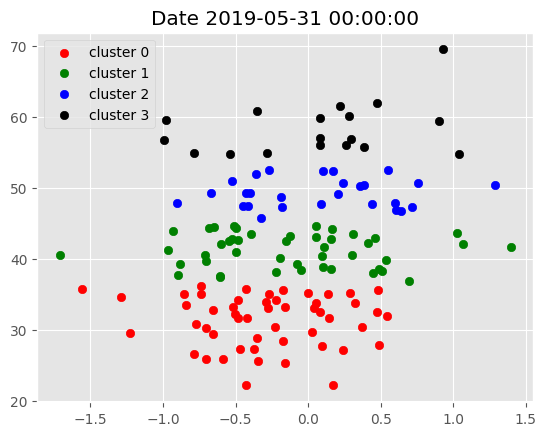

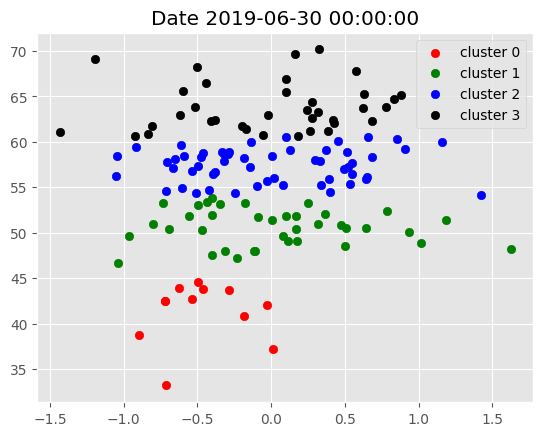

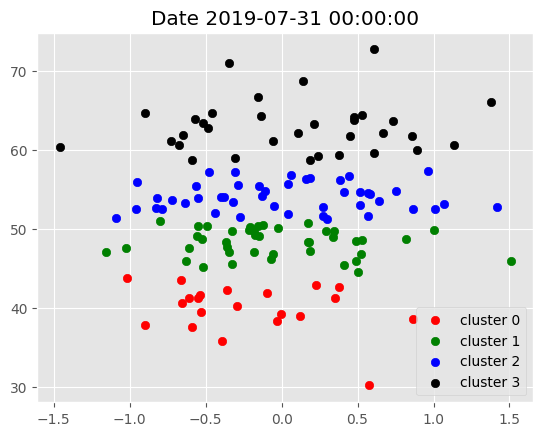

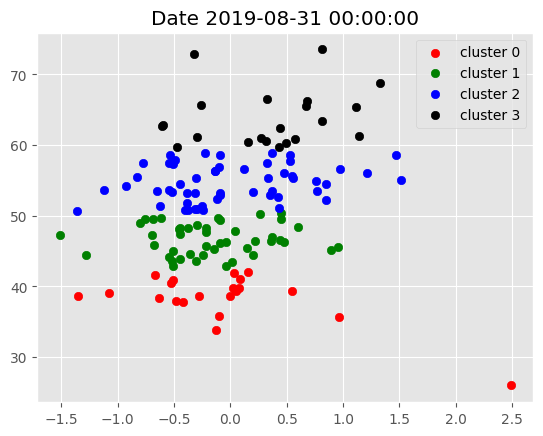

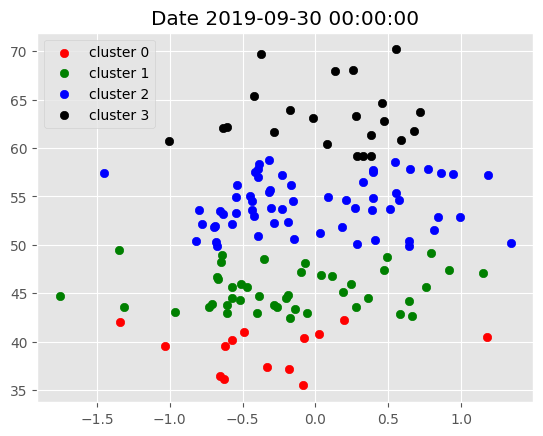

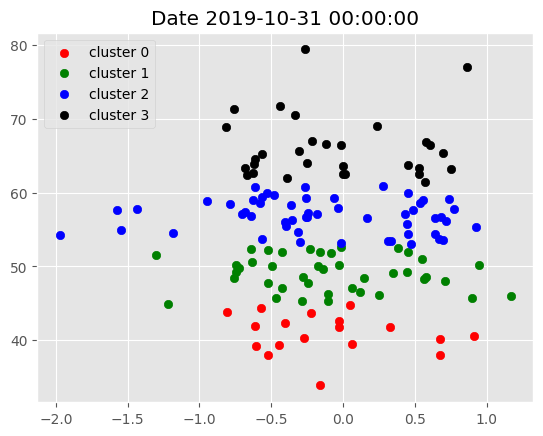

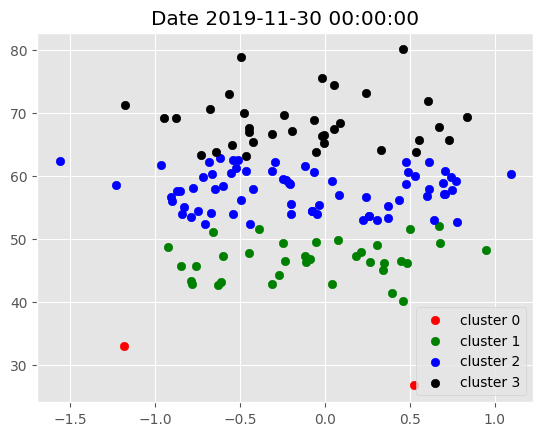

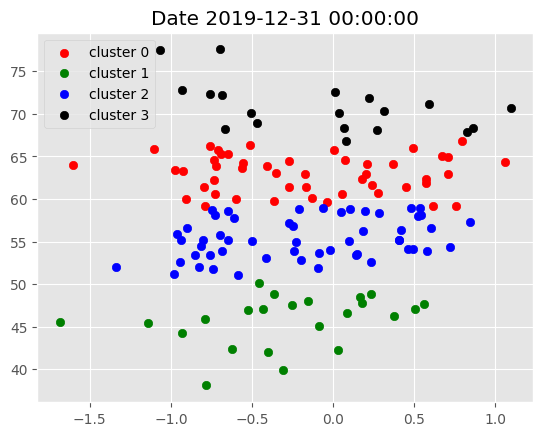

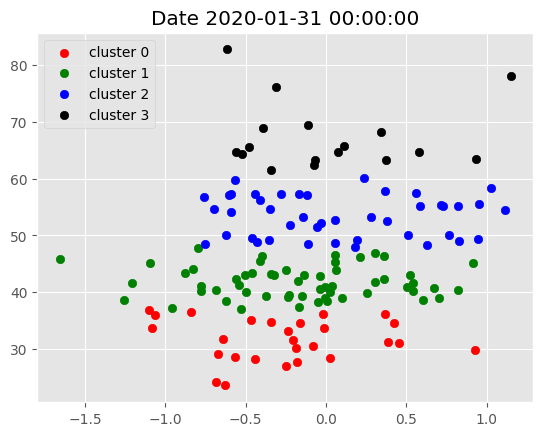

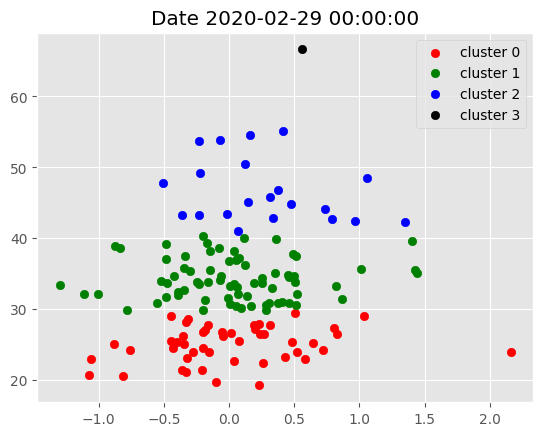

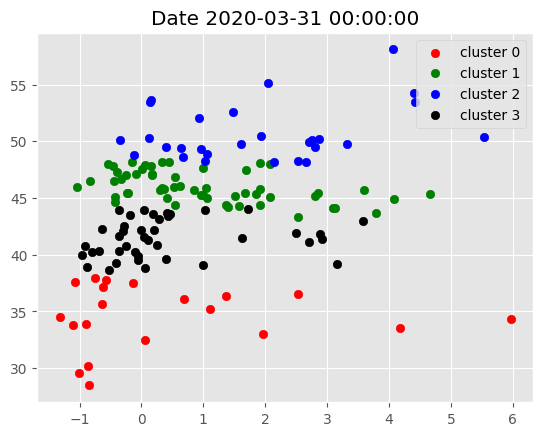

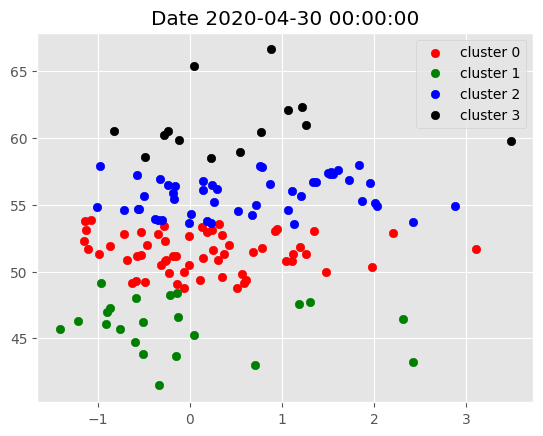

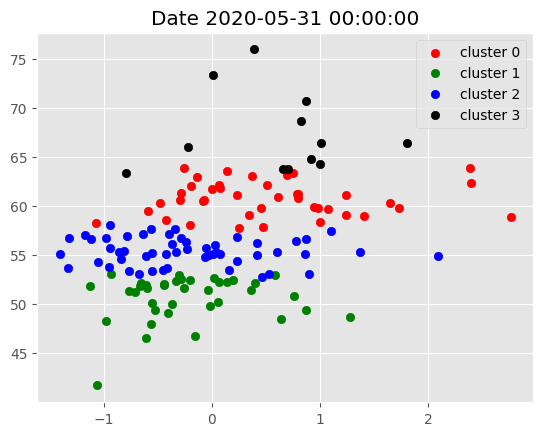

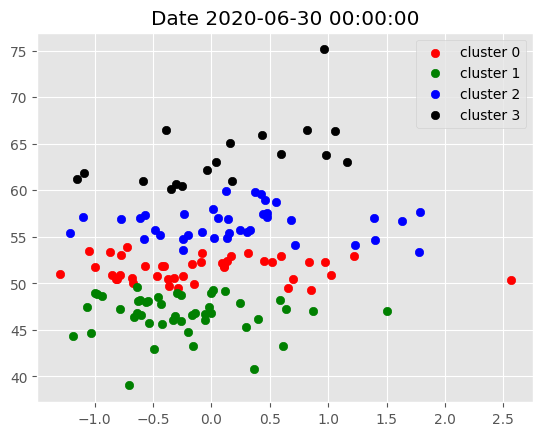

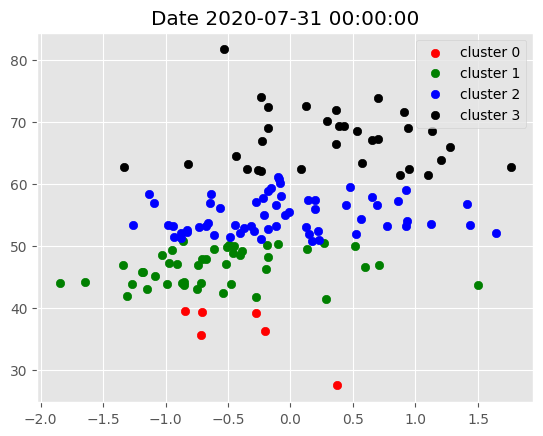

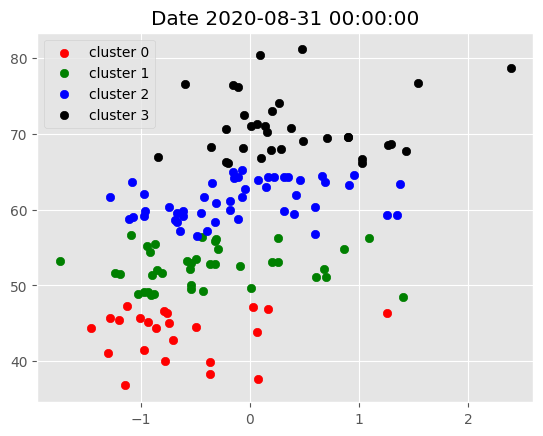

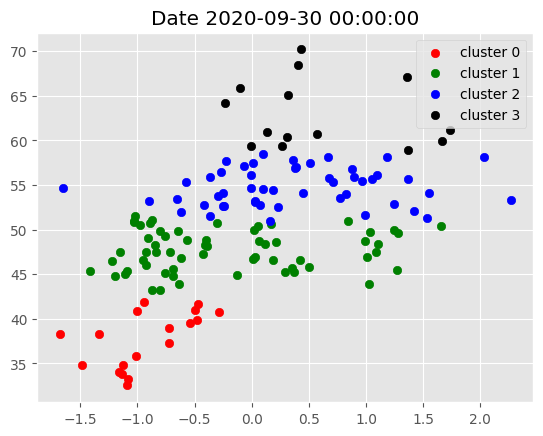

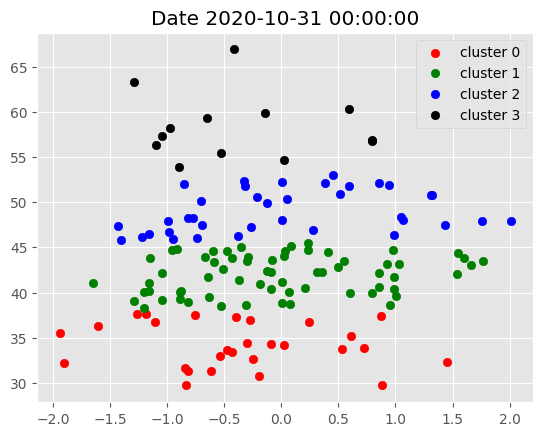

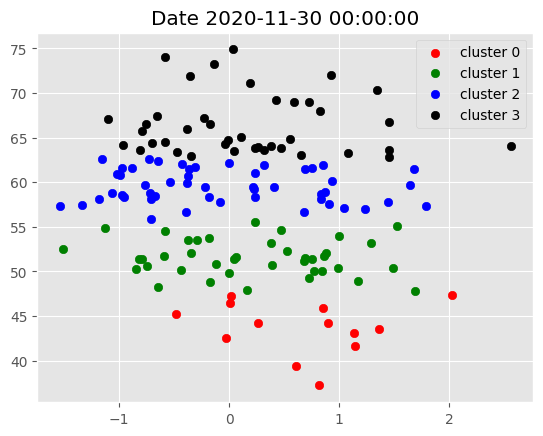

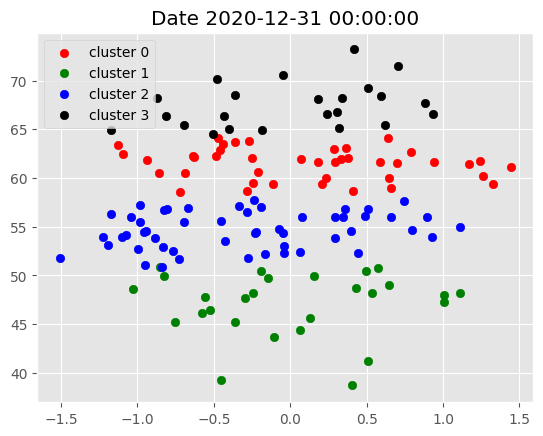

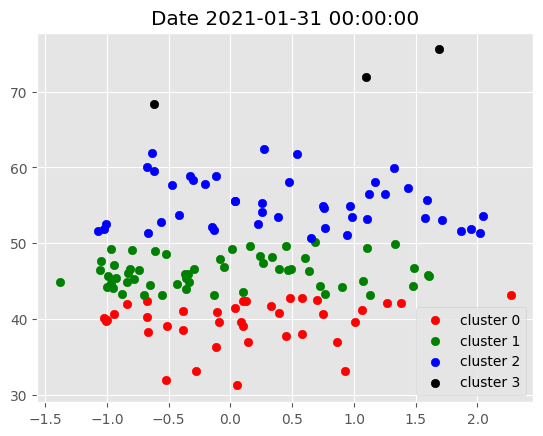

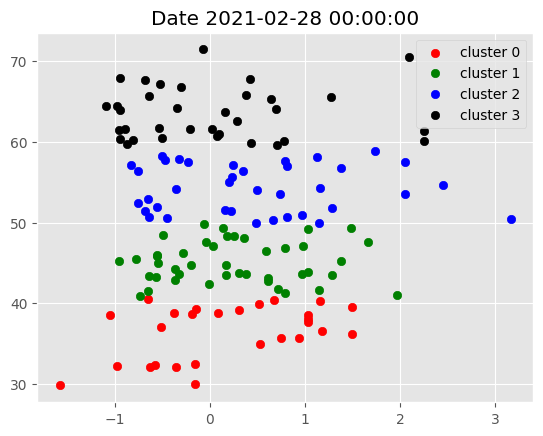

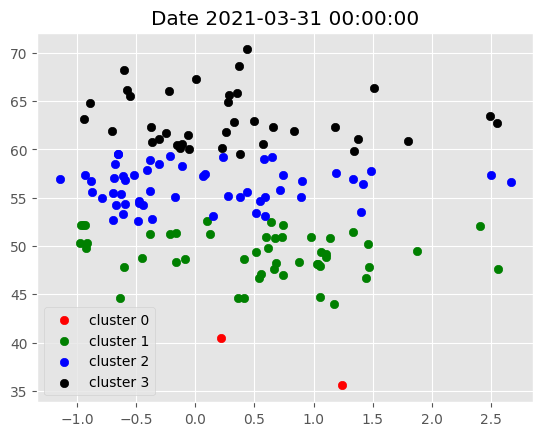

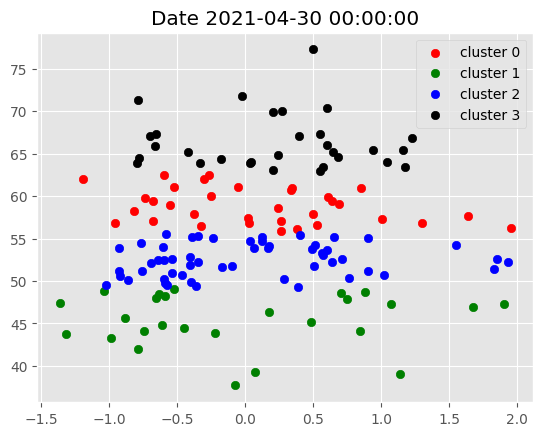

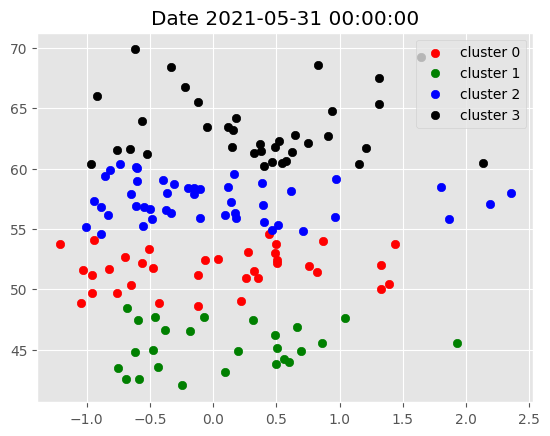

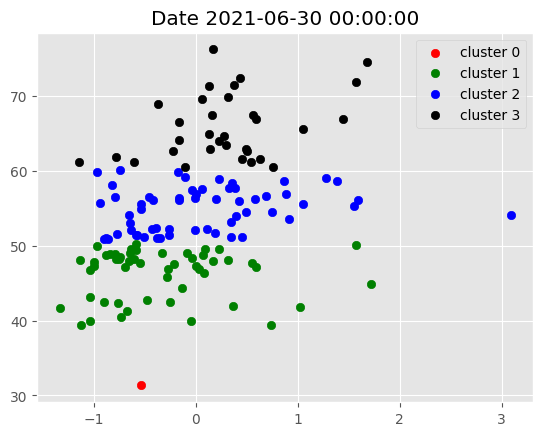

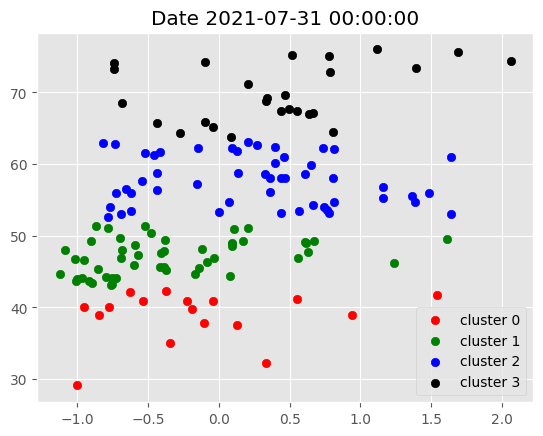

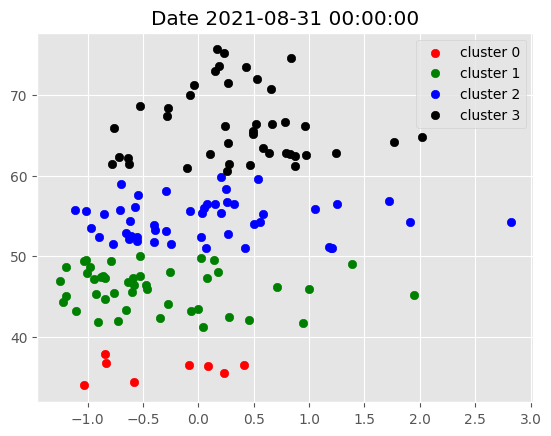

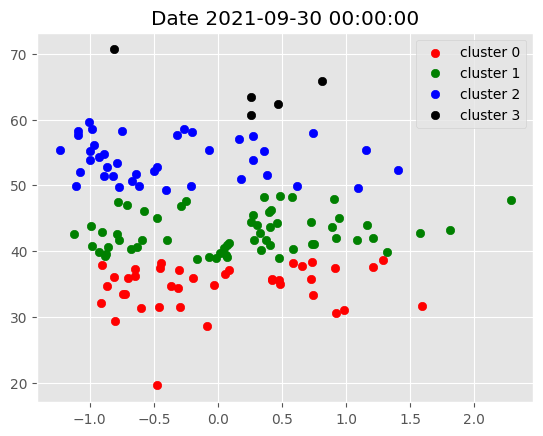

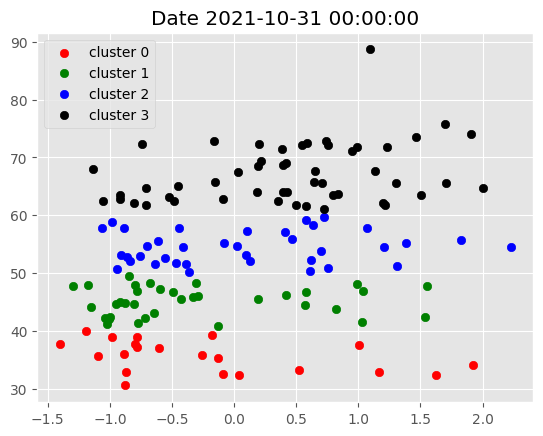

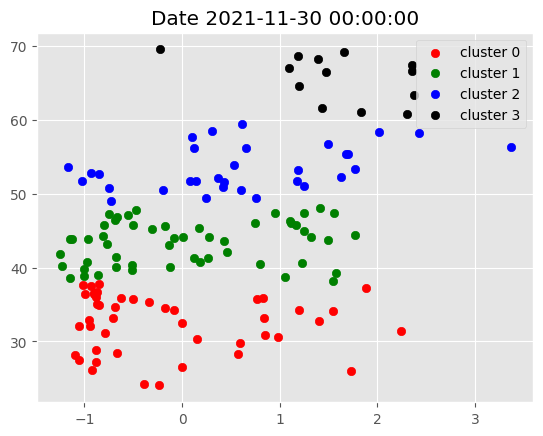

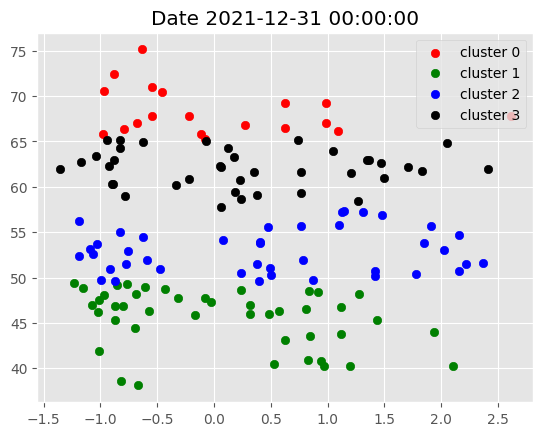

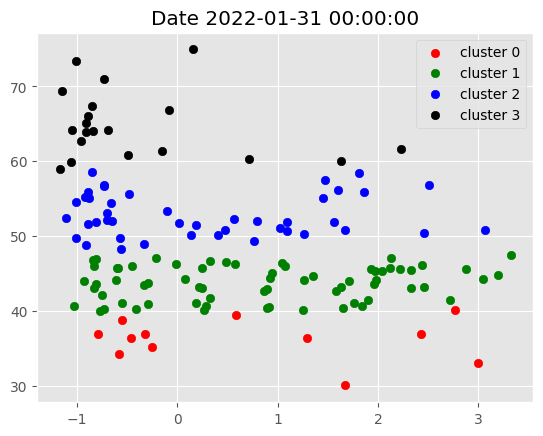

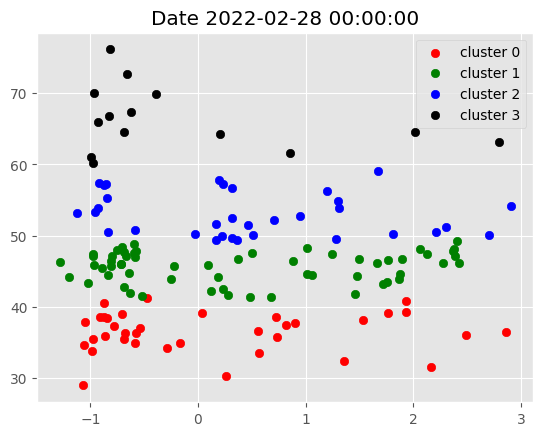

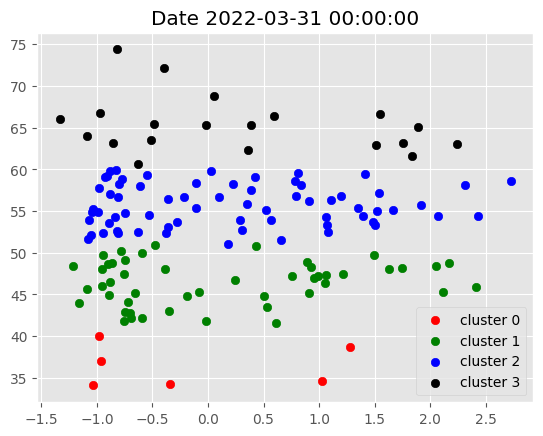

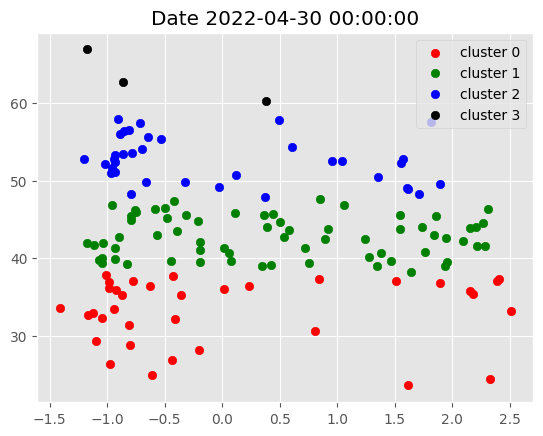

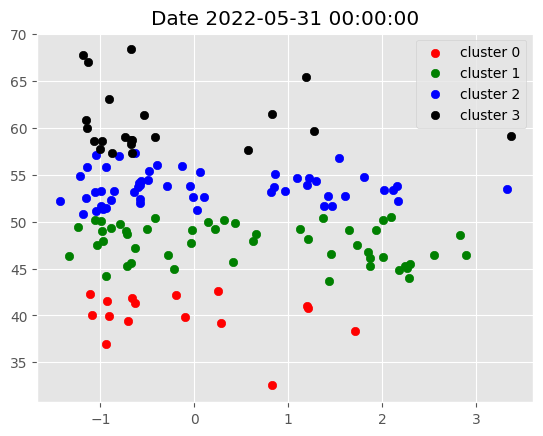

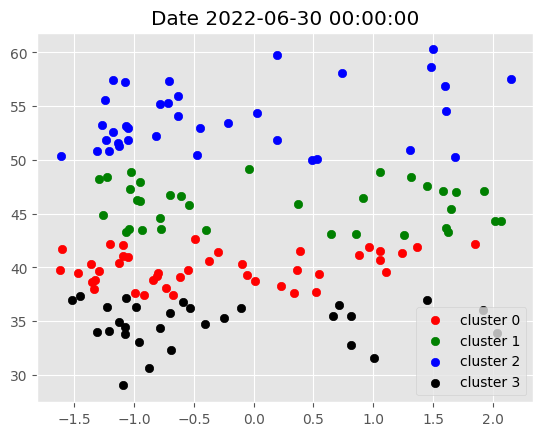

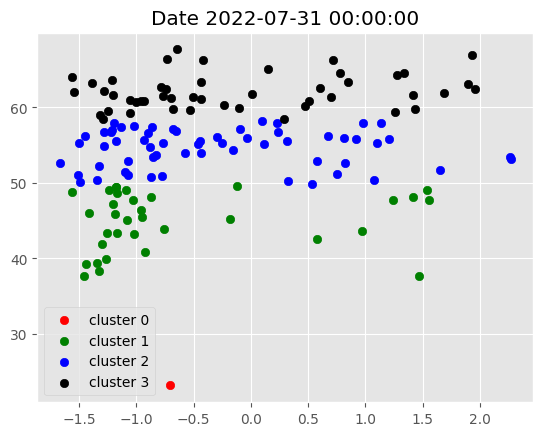

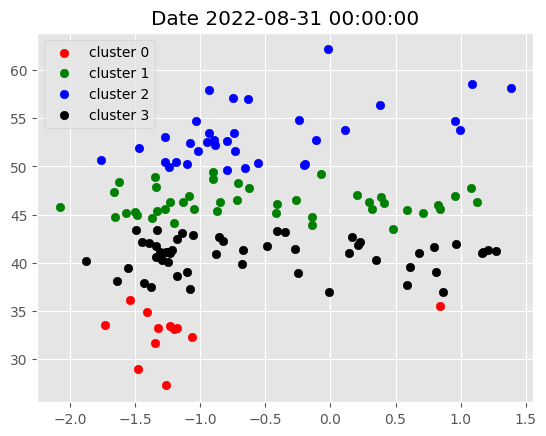

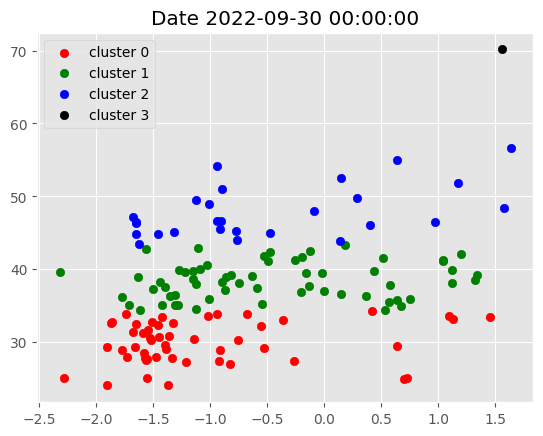

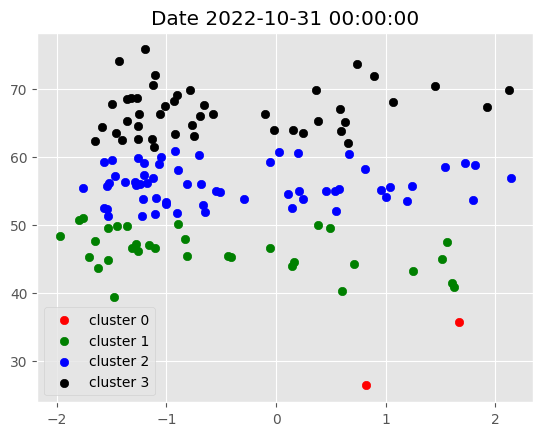

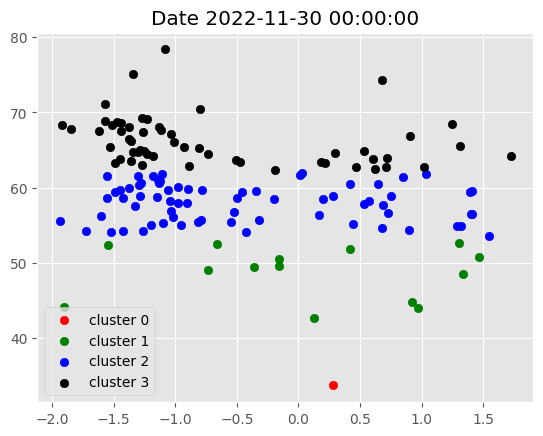

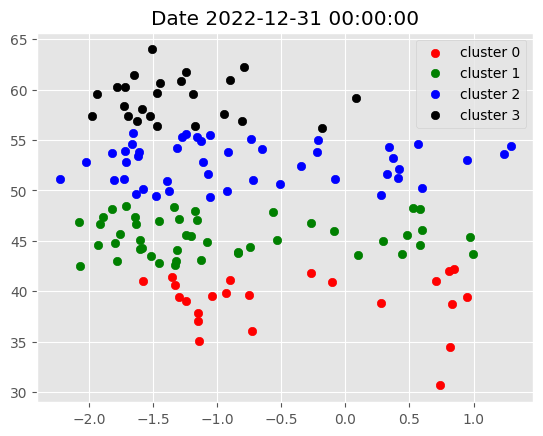

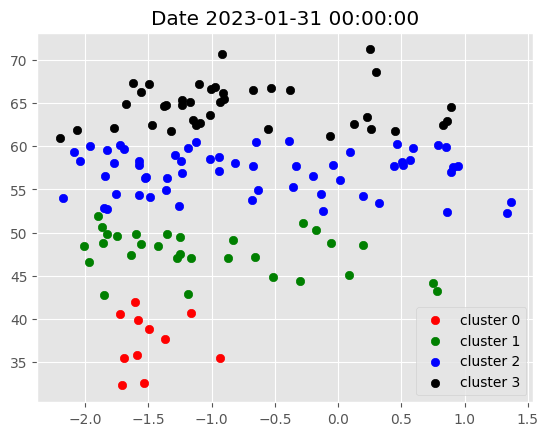

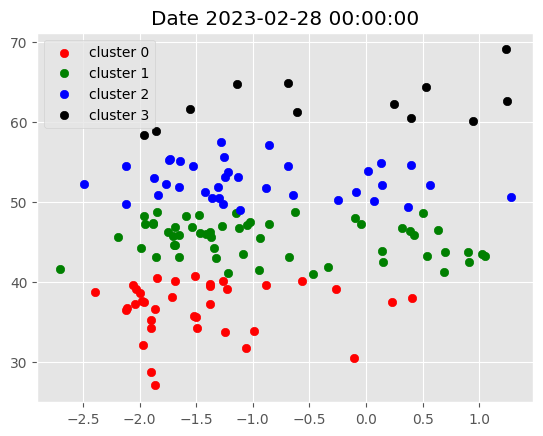

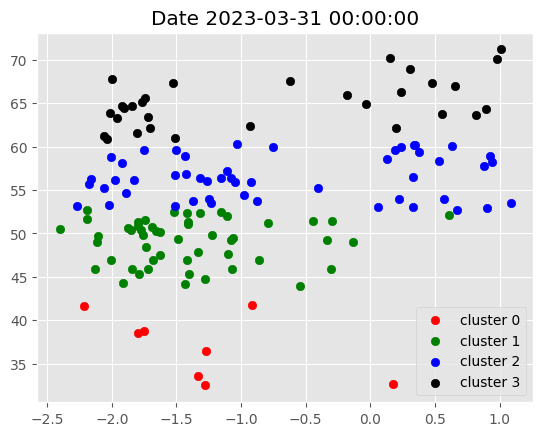

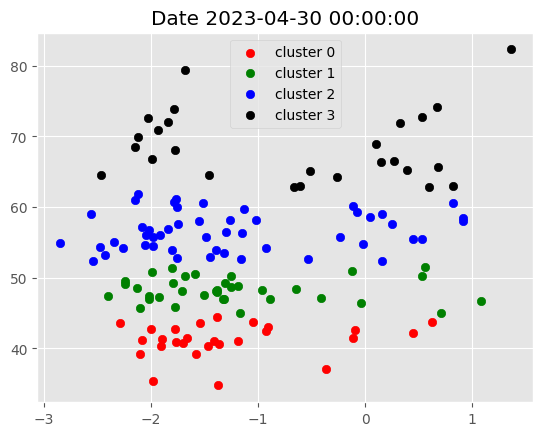

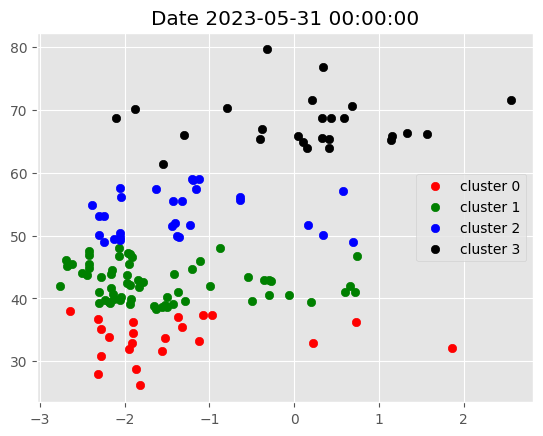

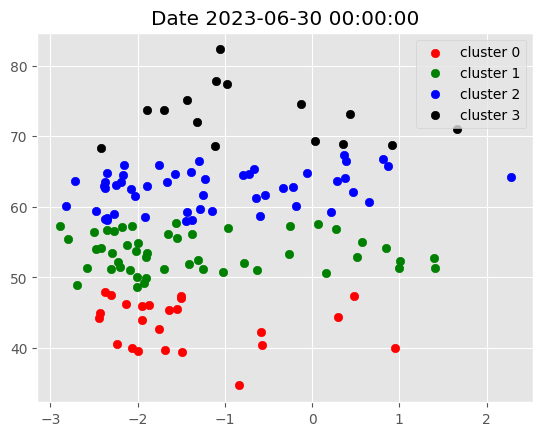

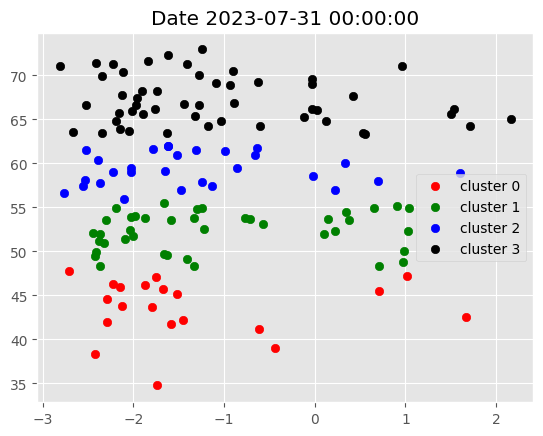

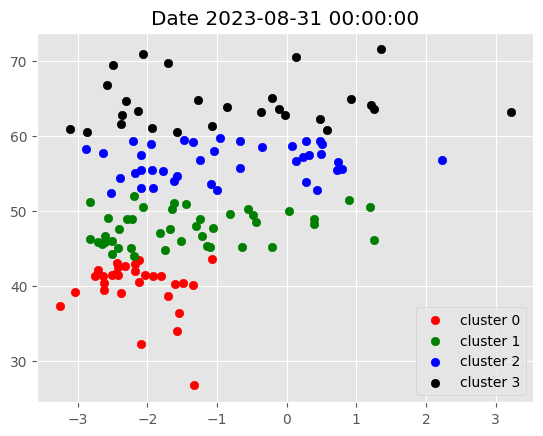

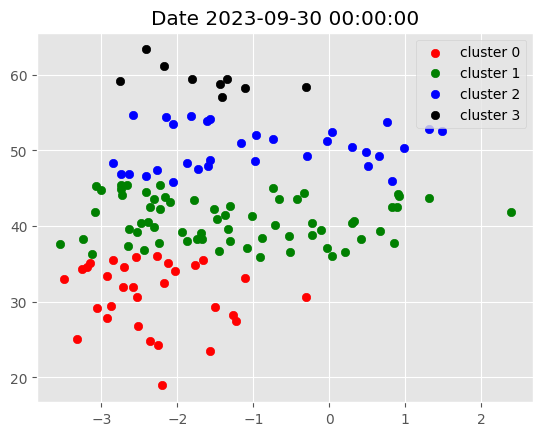

In [57]:
plt.style.use('ggplot')
for i in data.index.get_level_values('date').unique().tolist():
    g = data.xs(i, level = 0)
    plt.title(f'Date {i}')
    plot_clusters(g)

In [54]:
target_rsi_values = [30,45,55,70]
initial_centroids = np.zeros((len(target_rsi_values), 18))
initial_centroids[:,6] = target_rsi_values
initial_centroids


array([[ 0.,  0.,  0.,  0.,  0.,  0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]])

7. Select assets based on the cluster and form the portfolio

In [63]:
filtered_df = data[data['cluster'] == 3].copy()
filtered_df = filtered_df.reset_index(level = 1)
filtered_df.index = filtered_df.index+pd.DateOffset(1)
filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])
dates = filtered_df.index.get_level_values('date').unique().tolist()
fixed_dates = {}
for d in dates:
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level = 0).index.tolist()

fixed_dates

{'2017-11-01': ['AAPL',
  'ACN',
  'ADBE',
  'AMAT',
  'AMZN',
  'AVGO',
  'AXP',
  'BAC',
  'CAT',
  'COP',
  'CRM',
  'CTSH',
  'DE',
  'DHR',
  'DLTR',
  'ELV',
  'EOG',
  'GOOG',
  'GOOGL',
  'INTC',
  'ISRG',
  'JPM',
  'MA',
  'MAR',
  'MCD',
  'MET',
  'META',
  'MMM',
  'MPC',
  'MSFT',
  'MU',
  'NEE',
  'NVDA',
  'NXPI',
  'ORCL',
  'PYPL',
  'SHW',
  'STZ',
  'TXN',
  'UNH',
  'V',
  'VLO',
  'WMT',
  'XOM'],
 '2017-12-01': ['AMZN',
  'AXP',
  'AZO',
  'BA',
  'BAC',
  'BRK-B',
  'CAT',
  'COST',
  'CSCO',
  'DE',
  'DLTR',
  'ELV',
  'HD',
  'HON',
  'JPM',
  'KR',
  'LUV',
  'MAR',
  'MMM',
  'NKE',
  'ORLY',
  'OXY',
  'SCHW',
  'UNH',
  'UNP',
  'VLO',
  'VZ',
  'WMT'],
 '2018-01-01': ['BA',
  'CAT',
  'CVX',
  'DE',
  'FCX',
  'FDX',
  'HAL',
  'HD',
  'LOW',
  'LUV',
  'MAR',
  'OXY',
  'RTX',
  'STZ',
  'TXN',
  'UAL',
  'UNP',
  'VLO'],
 '2018-02-01': ['ABT',
  'ADBE',
  'AMZN',
  'BA',
  'BAC',
  'BRK-B',
  'CHTR',
  'CRM',
  'CTSH',
  'DG',
  'EA',
  'GD',
  'GOOG'

In [64]:
# Portfolio Optimization
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices, lower_bound = 0):
    returns = expected_returns.mean_historical_return(prices =  prices,
                                                      frequency = 252)
    cov = risk_models.sample_cov(prices = prices,
                                 frequency = 252)
    ef = EfficientFrontier(expected_returns = returns,
                           cov_matrix = cov,
                           weight_bounds = (lower_bound,.1),
                           solver = 'SCS')
    weights = ef.max_sharpe()
    return ef.clean_weights()


In [68]:
stocks = data.index.get_level_values('ticker').unique().tolist()
new_df = yf.download(tickers = stocks,
                     start = data.index.get_level_values('date').unique()[0] - pd.DateOffset(months = 12),
                     end = data.index.get_level_values('date').unique()[-1])
new_df

Price       Adj Close                                                 \
Ticker            AAL        AAPL        ABBV        ABT         ACN   
Date                                                                   
2016-10-31  39.134331   26.212473   40.245129  34.293453  103.569633   
2016-11-01  38.363201   25.739204   40.728519  34.127396  103.480545   
2016-11-02  38.276459   25.762285   40.973835  33.821533  105.681297   
2016-11-03  38.054211   25.486145   40.324490  33.541870  104.202255   
2016-11-04  38.402088   25.256414   40.432713  34.162361  104.451714   
...               ...         ...         ...        ...         ...   
2023-09-25  12.910000  175.386337  150.264954  95.991318  313.318970   
2023-09-26  12.700000  171.282578  149.545929  94.770134  307.012878   
2023-09-27  12.610000  169.758591  148.788055  94.080750  310.739227   
2023-09-28  12.920000  170.017578  147.933014  96.631454  297.286835   
2023-09-29  12.810000  170.535538  144.833450  95.380722  303.553406   

Price                                                                  ...  \
Ticker            ADBE         ADP        ADSK        AIG        AMAT  ...   
Date                                                                   ...   
2016-10-31  107.510002   73.831528   72.279999  50.462051   26.606327  ...   
2016-11-01  106.870003   73.712784   70.099998  49.627823   26.441633  ...   
2016-11-02  105.889999   76.307823   68.680000  49.521503   26.157999  ...   
2016-11-03  107.169998   75.756615   67.610001  47.558643   25.865229  ...   
2016-11-04  106.199997   75.544601   69.440002  46.928886   25.819477  ...   
...                ...         ...         ...        ...         ...  ...   
2023-09-25  511.600006  235.844086  205.669998  61.170822  135.818924  ...   
2023-09-26  506.299988  233.112457  201.660004  60.314251  133.323090  ...   
2023-09-27  502.600006  238.408691  202.279999  60.068115  134.297562  ...   
2023-09-28  504.670013  239.076843  207.889999  60.333946  137.439728  ...   
2023-09-29  509.899994  236.394348  206.910004  59.664444  137.668427  ...   

Price         Volume                                                           \
Ticker             V      VLO     VRTX        VZ       WBA      WDC       WFC   
Date                                                                            
2016-10-31  10024000  4969500  1928200  12459400   4662100  3363200  20115900   
2016-11-01  10881500  7816800  2458200  13229400   5130800  3821100  20020200   
2016-11-02   9170900  7317600  2580400  16488200   9783100  4216200  19566600   
2016-11-03   7563100  3855900  2371000  12605100   4586500  3192600  14982700   
2016-11-04   7588100  3729900  1902100  14410200   7023900  2705600  27391600   
...              ...      ...      ...       ...       ...      ...       ...   
2023-09-25   5921600  3241900   698100  17616900   6891000  2685900  10624000   
2023-09-26   6193200  4936800   633600  18841600   7570500  3571100  15219400   
2023-09-27   6006700  3644000   860600  22083500  10182900  2547800  11815500   
2023-09-28   4203900  3587300   578900  18772100   7291500  3282000  12454600   
2023-09-29   6044200  4302200   896800  19759400  25659100  2512000  13119100   

Price                                    
Ticker           WMT     WYNN       XOM  
Date                                     
2016-10-31  19167000  1341600  16663800  
2016-11-01  26515800  3722300  13050600  
2016-11-02  22935900  2542400  11226100  
2016-11-03  20411700  9050400   8836500  
2016-11-04  21786300  3223800  13877100  
...              ...      ...       ...  
2023-09-25  10459500  1387800  11316000  
2023-09-26  14435700  1454000  11805400  
2023-09-27  15711000  2050000  23976200  
2023-09-28  11617200  1290400  16808100  
2023-09-29  18842400  1326800  18810700  

[1740 rows x 930 columns]